In [1]:
from infomap import Infomap
import numpy as np
from info_map_helpers import expand_labels
import matplotlib.pyplot as plt
from pyvis import colorize_segmented_image
from skimage.future.graph import RAG as rag
base = '/bigstore/GeneralStorage/Evan/InfoMap/Cell_Type_Region_Conditional_Information/'

In [4]:
nuc_centers = np.load(base+'nuclei_centers.npy')
cell_seg_map = np.load(base+'cell_seg_map.npy')

In [5]:
nuc_centers.shape, cell_seg_map.shape

((6958, 3), (1338, 916, 5))

In [43]:
np.max(nuc_centers, 0), np.min(nuc_centers, 0)  # could use this to build zero volumes with ones at centers

(array([ 6311.56794253, -2139.0444514 ,    11.57054986]),
 array([ 2.30783682e+03, -4.87684376e+03,  6.64906185e-01]))

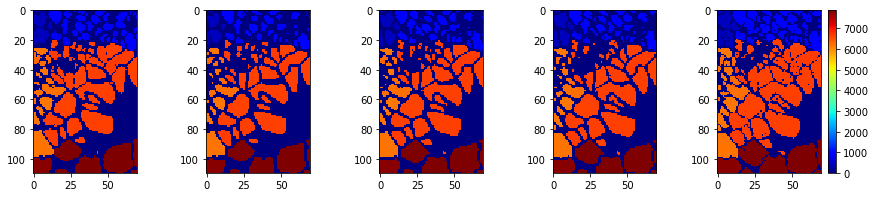

In [36]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(151+i)
    plt.imshow(cell_seg_map[190:300,200:270,i], cmap='jet')  # 580:700,200:270
    if i==4:
        plt.colorbar()
plt.show()

In [46]:
nuc_centers -= np.min(nuc_centers, 0)

In [50]:
nuc_centers *=  (np.array([1338, 916, 5])/np.max(nuc_centers, 0))

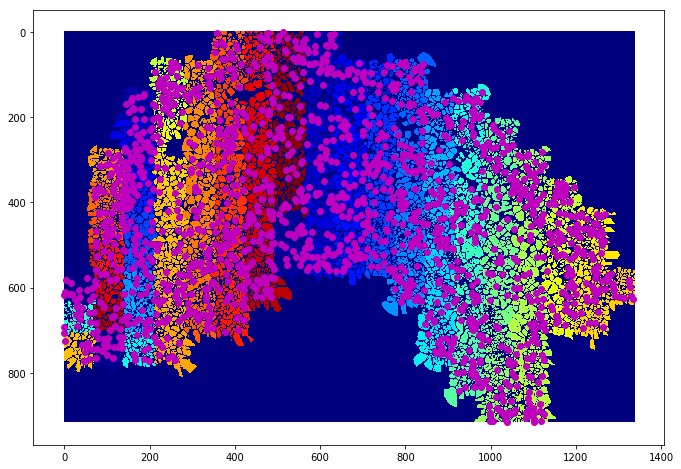

In [78]:
plt.figure(figsize=(12,8))
plt.imshow(cell_seg_map[:,:,0].T, cmap='jet')
plt.scatter(*nuc_centers[nuc_centers[:,2]<2, :2].T, alpha=1, c='m')
plt.show()

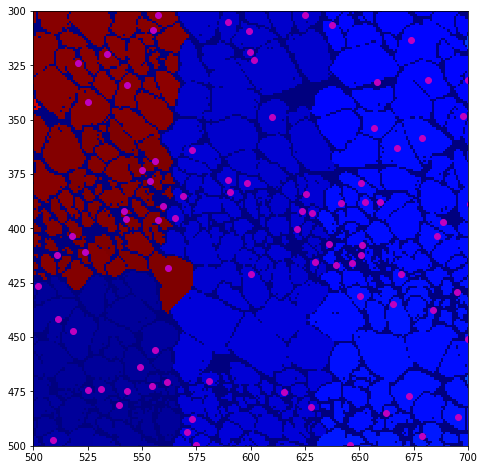

In [94]:
plt.figure(figsize=(12,8))
plt.imshow(cell_seg_map[:,:,4].T, cmap='jet')
plt.scatter(*nuc_centers[nuc_centers[:,2]<2, :2].T, alpha=1, c='m')
plt.ylim(500,300)
plt.xlim(500,700)
plt.show()

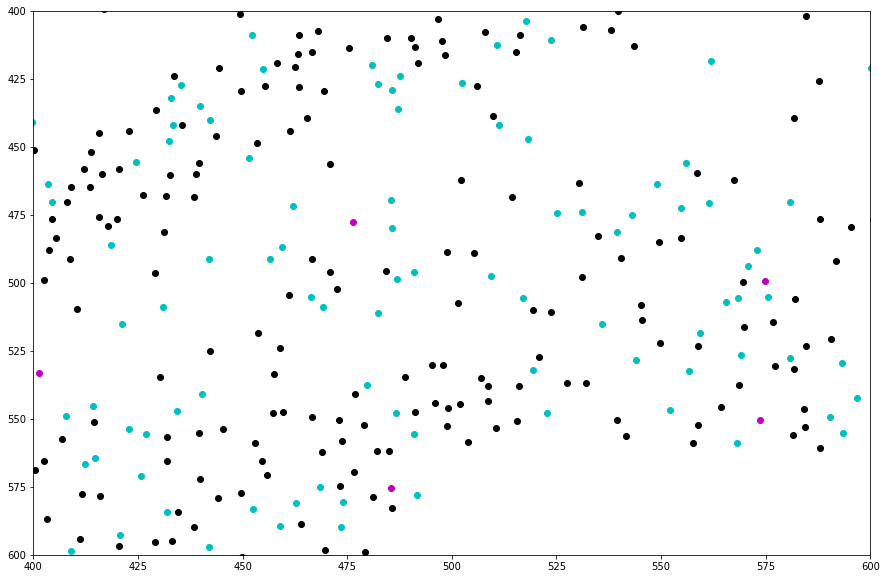

In [97]:
plt.figure(figsize=(15,10))
plt.scatter(*nuc_centers[nuc_centers[:,2]<1, :2].T, alpha=1, c='m')
plt.scatter(*nuc_centers[(nuc_centers[:,2]>1)&(nuc_centers[:,2]<2), :2].T, alpha=1, c='c')
plt.scatter(*nuc_centers[(nuc_centers[:,2]>2)&(nuc_centers[:,2]<3), :2].T, alpha=1, c='k')
plt.ylim(600,400)
plt.xlim(400,600)
plt.show()

In [115]:
%matplotlib notebook

In [170]:
n_cells = cell_seg_map.max()  # 10324 cells here!
n_cells

10324

Goal: Construct a graph based on cell neighbors. Just expand (dilate) labels a certain distance and only count all the touching labels

In [7]:
colors = colorize_segmented_image(expand_labels(cell_seg_map[:,:,0]+1, 2), 'rgb', return_colors=True)

/home/evan/repos/PyImages/pyvis.py:87: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgb_img[list(regions[i].coords.T)] = colors[i]  # won't use the 1st color


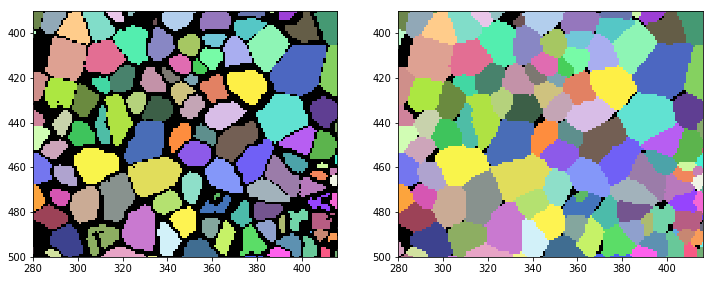

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(colorize_segmented_image(expand_labels(cell_seg_map[:,:,0]+1, 0), 'rgb', colors=colors), cmap='jet')
#plt.scatter(nuc_centers[3, 0], nuc_centers[3, 1], alpha=1, c='m')
plt.xlim(280,416)
plt.ylim(500,390)
plt.subplot(122)
plt.imshow(colorize_segmented_image(expand_labels(cell_seg_map[:,:,0]+1, 2), 'rgb', colors=colors), cmap='jet')
#plt.scatter(nuc_centers[3, 0], nuc_centers[3, 1], alpha=1, c='m')
plt.xlim(280,416)
plt.ylim(500,390)
plt.show()

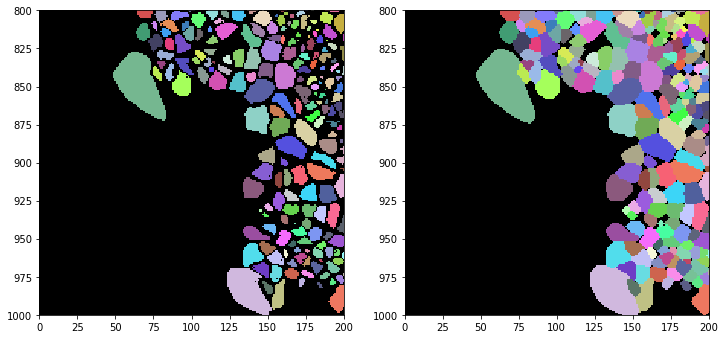

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(colorize_segmented_image(expand_labels(cell_seg_map[:,:,0]+1, 0), 'rgb', colors=colors), cmap='jet')
#plt.scatter(nuc_centers[3, 0], nuc_centers[3, 1], alpha=1, c='m')
plt.xlim(0,200)
plt.ylim(1000,800)
plt.subplot(122)
plt.imshow(colorize_segmented_image(expand_labels(cell_seg_map[:,:,0]+1, 2), 'rgb', colors=colors), cmap='jet')
#plt.scatter(nuc_centers[3, 0], nuc_centers[3, 1], alpha=1, c='m')
plt.xlim(0,200)
plt.ylim(1000,800)
plt.show()

# Object Development

In [11]:
from skimage.measure import label

In [15]:
# keep expanding labels until it's one contiguous block
for i in range(100):
    expanded = expand_labels(cell_seg_map[:,:,0]+1, 3)
    if np.max(label(expanded>0))==1:
        break

# use a region adjacency graph (rag) on expanded labels to detect
exp_rag = rag(expanded)

1

In [173]:
exp_rag = rag(expanded)

In [160]:
def imshow_border_cells(ax, cell, seg, edges, colors, lims=None, return_lims=False):
    ax.imshow(colorize_segmented_image(seg, 'rgb', colors=colors), cmap='jet')
    print('N Connected Cells:', len([i for i in edges if cell in i and 0 not in i]))
    xs, ys = [], []
    for i in np.unique([i for i in exp_rag.edges if cell in i and 0 not in i]):
        if i!=cell:
            c='orange'
        else:
            c='blue'
        coords = np.where(seg==i)
        xs.append(max(coords[1]))
        ys.append(max(coords[0]))
        xs.append(min(coords[1]))
        ys.append(min(coords[0]))
        ax.scatter(coords[1][int(len(coords[0])/2)], coords[0][int(len(coords[0])/2)], label=str(cell), c=c, 
                    edgecolors='w')
    if type(lims)==type(None):
        ax.set(xlim=(min(xs)-5, max(xs)+5), ylim=(min(ys)-5, max(ys)+5))
    else:
        ax.set(xlim=lims[0], ylim=lims[1])

    if return_lims:
        return lims


N Connected Cells: 5
N Connected Cells: 5


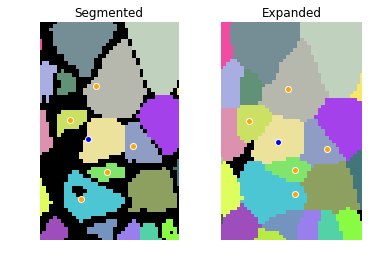

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set(title='Segmented')
ax2.set(title='Expanded')
cell = np.random.choice(np.arange(10000), 1)
lims = imshow_border_cells(ax1, cell, cell_seg_map[:,:,0]+1, exp_rag.edges, colors, return_lims=True)
imshow_border_cells(ax2, cell, expanded, exp_rag.edges, colors, lims=lims)
ax1.axis('off')
ax2.axis('off')
plt.show()

N Connected Cells: 6
N Connected Cells: 6


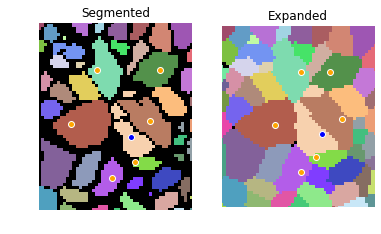

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set(title='Segmented')
ax2.set(title='Expanded')
cell = np.random.choice(np.arange(10000), 1)
lims = imshow_border_cells(ax1, cell, cell_seg_map[:,:,0]+1, exp_rag.edges, colors, return_lims=True)
imshow_border_cells(ax2, cell, expanded, exp_rag.edges, colors, lims=lims)
ax1.axis('off')
ax2.axis('off')
plt.show()

N Connected Cells: 3
N Connected Cells: 3


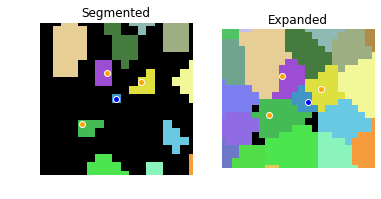

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set(title='Segmented')
ax2.set(title='Expanded')
cell = np.random.choice(np.arange(n_cells), 1)
lims = imshow_border_cells(ax1, cell, cell_seg_map[:,:,0]+1, exp_rag.edges, colors, return_lims=True)
imshow_border_cells(ax2, cell, expanded, exp_rag.edges, colors, lims=lims)
ax1.axis('off')
ax2.axis('off')
plt.show()

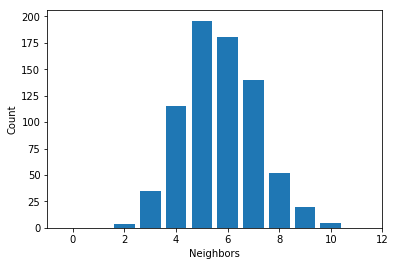

In [187]:
# histogram of neighbors because some cells have a lot and some only have one
plt.bar(np.arange(12), [len(np.where(np.array(neighbors)==i)[0]) for i in range(12)])
plt.ylabel('Count')
plt.xlabel('Neighbors')
plt.show()

Cells are mostly pentagons or hexagons, at least in 2d, pretty cool!